Total data : 100 GB

In [ ]:
import os

h5_count = 0
jpg_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/megadepth-v1-p2'):
    for filename in filenames:
        if filename.endswith('.h5'):
            h5_count += 1
        elif filename.endswith('.jpg'):
            jpg_count += 1

print(f'Number of .h5 files: {h5_count}')
print(f'Number of .jpg files: {jpg_count}')


In [ ]:
import os

h5_count = 0
jpg_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/megadepth-v1-p4'):
    for filename in filenames:
        if filename.endswith('.h5'):
            h5_count += 1
        elif filename.endswith('.jpg'):
            jpg_count += 1

print(f'Number of .h5 files: {h5_count}')
print(f'Number of .jpg files: {jpg_count}')


# MESA (Method 1)

In [ ]:
!pip install segment_anything

> To download SAM model

In [ ]:
import numpy as np
import networkx as nx
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from scipy.optimize import minimize

## Data Loading (5 folders)

In [ ]:
import os
import random
from pathlib import Path

# Base dataset directory
root_dir = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2"

# Get list of all folder names (0015, 0022, etc.)
all_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

# Select only 8 folders (either randomly or first 8)
selected_folders = all_folders[:5]  # or use random.sample(all_folders, 8)

# Collect image and depth file paths
selected_data = []

for folder in selected_folders:
    image_folder = os.path.join(root_dir, folder, "dense0", "imgs")
    depth_folder = os.path.join(root_dir, folder, "dense0", "depths")

    if os.path.exists(image_folder) and os.path.exists(depth_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(image_folder, image_file)

                # Replace extension with .h5 to find matching depth file
                depth_filename = Path(image_file).stem + ".h5"
                depth_path = os.path.join(depth_folder, depth_filename)

                if os.path.exists(depth_path):
                    selected_data.append((image_path, depth_path))

print(f"Selected {len(selected_data)} image-depth pairs from 5 folders.")


Selected 3416 image-depth pairs from 5 folders.


# Step 1: Segmentation

In [ ]:
import cv2
import numpy as np
import h5py
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the MegaDepth dataset image and depth map
def load_megadepth_image(image_path, depth_path):
    """Loads an image and its corresponding depth map from MegaDepth dataset."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load depth map from .h5 file
    with h5py.File(depth_path, 'r') as f:
        depth = np.array(f["depth"])  # Extract depth data

    return image, depth

# Initialize the SAM model with the correct checkpoint
def initialize_sam(model_path):
    """Initializes the Segment Anything Model (SAM)."""
    sam = sam_model_registry["vit_h"](checkpoint=model_path)  # Ensure model type is correct
    sam_mask_generator = SamAutomaticMaskGenerator(sam)  # Automatic mask generation
    return sam_mask_generator

# Get segmentation masks using SAM
def segment_image(image, sam_mask_generator):
    """Generates segmentation masks using SAM."""
    masks = sam_mask_generator.generate(image)
    return masks


# Step 2: MRG

In [ ]:
import networkx as nx
import numpy as np

def construct_mrg2(masks):
    G = nx.Graph()

    # Add nodes
    for idx, mask in enumerate(masks):
        G.add_node(idx, mask=mask["segmentation"])

    print(f"Total Nodes: {G.number_of_nodes()}")  # Debugging

    # Define edges based on adjacency & depth similarity
    for i, mask_i in enumerate(masks):
        for j, mask_j in enumerate(masks):
            if i != j:
                # Ensure boolean masks
                mask_i_bin = mask_i["segmentation"] > 0
                mask_j_bin = mask_j["segmentation"] > 0

                # IoU Calculation
                intersection = np.logical_and(mask_i_bin, mask_j_bin).sum()
                union = np.logical_or(mask_i_bin, mask_j_bin).sum()
                iou = intersection / union if union != 0 else 0

                # Depth Similarity
                depth_diff = np.abs(mask_i.get("depth_mean", 0) - mask_j.get("depth_mean", 0))
                depth_similarity = np.exp(-depth_diff / 10)  # Adjust scaling factor

                weight = iou * depth_similarity

                # Lower threshold & debug
                if weight > 0.1:
                    print(f"Edge: {i} - {j}, Weight: {weight}")
                    G.add_edge(i, j, weight=weight)

    print(f"Total Edges: {G.number_of_edges()}")  # Debugging
    return G


# Step 3: AMRF

In [ ]:
import networkx as nx
import numpy as np

def construct_amrf(masks, lambda_param=10):
    """
    Constructs an Area Markov Random Field (AMRF) using IoU and depth similarity.
    This extends construct_mrg2() by defining MRF energy functions but does NOT solve it.
    """
    G = nx.Graph()

    # Add nodes (each segment as a node)
    for idx, mask in enumerate(masks):
        G.add_node(idx, mask=mask["segmentation"], depth_mean=mask.get("depth_mean", 0))

    print(f"Total Nodes: {G.number_of_nodes()}")  # Debugging

    # Define edges with MRF-based weights
    for i, mask_i in enumerate(masks):
        for j, mask_j in enumerate(masks):
            if i < j:  # Avoid duplicate edges
                # Ensure boolean masks
                mask_i_bin = mask_i["segmentation"] > 0
                mask_j_bin = mask_j["segmentation"] > 0

                # Compute IoU
                intersection = np.logical_and(mask_i_bin, mask_j_bin).sum()
                union = np.logical_or(mask_i_bin, mask_j_bin).sum()
                iou = intersection / union if union != 0 else 0

                # Depth similarity
                depth_diff = np.abs(mask_i.get("depth_mean", 0) - mask_j.get("depth_mean", 0))
                depth_similarity = np.exp(-depth_diff / 10)  # Scaling factor

                # Pairwise MRF energy function (Spatial Smoothness)
                weight = lambda_param * iou * depth_similarity

                # Lower threshold for meaningful edges
                if weight > 0.1:
                    print(f"Edge: {i} - {j}, Weight: {weight}")
                    G.add_edge(i, j, weight=weight)

    print(f"Total Edges: {G.number_of_edges()}")  # Debugging
    return G



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_amrf(G):
    """
    Visualizes the Area Markov Random Field (AMRF) graph.
    - Nodes are colored based on depth.
    - Edge thickness represents weights.
    """
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Extract node depth values
    depths = np.array([G.nodes[n]["depth_mean"] for n in G.nodes()])

    # Normalize depth values for colormap
    min_depth, max_depth = depths.min(), depths.max()
    depth_colors = (depths - min_depth) / (max_depth - min_depth + 1e-6)  # Normalize to [0,1]

    # Draw nodes with color mapping
    cmap = plt.get_cmap("coolwarm")
    node_colors = [cmap(val) for val in depth_colors]

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos, with_labels=True, node_size=500, node_color=node_colors,
        cmap=cmap, edge_color="gray", font_size=10, font_weight="bold"
    )

    # Draw edge weights
    edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Area Markov Random Field (AMRF) Graph")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Normalized Depth")
    plt.show()


# Step 4: Energy Minimisation using Graph cut

In [ ]:
!pip install PyMaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.4/894.4 kB 3.4 MB/s eta 0:00:0000:0100:01m


In [ ]:
import networkx as nx
import numpy as np
import maxflow  # PyMaxflow library

import numpy as np
from skimage.transform import resize

def compute_iou(mask1, mask2):
    """Computes Intersection over Union (IoU) between two segmentation masks."""

    # Ensure masks have the same shape
    if mask1.shape != mask2.shape:
        min_height = min(mask1.shape[0], mask2.shape[0])
        min_width = min(mask1.shape[1], mask2.shape[1])

        mask1 = resize(mask1.astype(float), (min_height, min_width), anti_aliasing=False) > 0.5
        mask2 = resize(mask2.astype(float), (min_height, min_width), anti_aliasing=False) > 0.5

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def apply_graph_cut(G1, G2):
    """
    Applies Graph Cut algorithm to match areas between two AMRF graphs.

    Args:
        G1 (nx.Graph): AMRF graph for Image 1.
        G2 (nx.Graph): AMRF graph for Image 2.

    Returns:
        matched_areas (list): List of matched area indices.
    """
    num_nodes1 = G1.number_of_nodes()
    num_nodes2 = G2.number_of_nodes()

    if num_nodes1 == 0 or num_nodes2 == 0:
        print("Error: One of the graphs is empty!")
        return []

    # Create a max-flow graph
    graph = maxflow.Graph[float]()
    node_ids1 = graph.add_nodes(num_nodes1)
    node_ids2 = graph.add_nodes(num_nodes2)

    # Add intra-graph edges (inside G1 and G2)
    for G, node_ids in zip([G1, G2], [node_ids1, node_ids2]):
        for i, j, data in G.edges(data=True):
            weight = data['weight']
            graph.add_edge(node_ids[i], node_ids[j], weight, weight)  # Bi-directional

    # Compute depth standard deviation for normalization
    all_depths = [G1.nodes[n]["depth_mean"] for n in G1.nodes] + [G2.nodes[n]["depth_mean"] for n in G2.nodes]
    depth_std = np.std(all_depths)

    # Add inter-graph edges (matching areas between G1 and G2)
    for i in G1.nodes:
        for j in G2.nodes:
            iou = compute_iou(G1.nodes[i]["mask"], G2.nodes[j]["mask"])
            depth_diff = abs(G1.nodes[i]["depth_mean"] - G2.nodes[j]["depth_mean"])
            depth_similarity = np.exp(-depth_diff / (depth_std + 1e-6))  # Normalize depth

            final_similarity = (iou * 0.7) + (depth_similarity * 0.3)  # Weighted combination

            if final_similarity > 0.2:  # Threshold
                graph.add_edge(node_ids1[i], node_ids2[j], final_similarity, final_similarity)

    # Add source/sink links for segmentation
    for i in range(num_nodes1):
        neighbor_weights = [G1.edges[i, j]['weight'] for j in G1.neighbors(i)] if len(list(G1.neighbors(i))) > 0 else [0]
        similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize
        graph.add_tedge(node_ids1[i], similarity, 1 - similarity)

    for i in range(num_nodes2):
        neighbor_weights = [G2.edges[i, j]['weight'] for j in G2.neighbors(i)] if len(list(G2.neighbors(i))) > 0 else [0]
        similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize
        graph.add_tedge(node_ids2[i], similarity, 1 - similarity)

    # Compute the min-cut
    graph.maxflow()

    # Extract matched areas (areas assigned to the same segment)
    matched_areas = [(i, j) for i in range(num_nodes1) for j in range(num_nodes2) if graph.get_segment(node_ids1[i]) == graph.get_segment(node_ids2[j])]

    print(f"Matched Areas Count: {len(matched_areas)}")
    return matched_areas


# Performing above steps on 2 Images

In [ ]:
# Load and process the first image
model_path = "/kaggle/input/sam/other/default/1/sam_vit_h_4b8939.pth"
image1_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg"
depth1_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/depths/1119628220_8328721e8b_o.h5"
image1, depth1 = load_megadepth_image(image1_path, depth1_path)

sam_mask_generator = initialize_sam(model_path)
masks1 = segment_image(image1, sam_mask_generator)

for mask in masks1:
    mask_coords = np.where(mask["segmentation"])
    mask["depth_mean"] = np.mean(depth1[mask_coords])

area_graph1 = construct_mrg2(masks1)
amrf_graph1 = construct_amrf(masks1)

Total Nodes: 117
Edge: 2 - 81, Weight: 0.20191001975594988
Edge: 3 - 32, Weight: 0.17568738857338553
Edge: 3 - 42, Weight: 0.17331340939205986
Edge: 4 - 61, Weight: 0.1249251331275509
Edge: 5 - 69, Weight: 0.20981399973154544
Edge: 10 - 52, Weight: 0.2686486652276286
Edge: 11 - 37, Weight: 0.1610598392152848
Edge: 12 - 113, Weight: 0.20657676376347936
Edge: 14 - 49, Weight: 0.11748597266955957
Edge: 14 - 76, Weight: 0.10546511098212635
Edge: 14 - 110, Weight: 0.9764617763730337
Edge: 16 - 48, Weight: 0.7575006512096122
Edge: 17 - 107, Weight: 0.13913521819012462
Edge: 18 - 26, Weight: 0.8242841801243161
Edge: 19 - 31, Weight: 0.44806575318795017
Edge: 19 - 33, Weight: 0.5218681025384408
Edge: 20 - 68, Weight: 0.39418969576724905
Edge: 20 - 74, Weight: 0.20260497114263837
Edge: 20 - 101, Weight: 0.3863514929700893
Edge: 21 - 53, Weight: 0.11259449431970532
Edge: 21 - 82, Weight: 0.1087011208433644
Edge: 22 - 27, Weight: 0.812035661218425
Edge: 25 - 75, Weight: 0.8075650990043373
Edge: 2

In [ ]:
# Load and process the second image
image2_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1125352430_fa4e56275f_o.jpg"
depth2_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/depths/1125352430_fa4e56275f_o.h5"
image2, depth2 = load_megadepth_image(image2_path, depth2_path)

masks2 = segment_image(image2, sam_mask_generator)

for mask in masks2:
    mask_coords = np.where(mask["segmentation"])
    mask["depth_mean"] = np.mean(depth2[mask_coords])

area_graph2 = construct_mrg2(masks2)
amrf_graph2 = construct_amrf(masks2)

# Now apply Graph Cut between both AMRFs
# matched_areas = apply_graph_cut(amrf_graph1, amrf_graph2)
# print(matched_areas)

Total Nodes: 133
Edge: 1 - 41, Weight: 0.29035069772447586
Edge: 1 - 54, Weight: 0.16715443038182143
Edge: 3 - 35, Weight: 0.7877078351840356
Edge: 3 - 50, Weight: 0.16358228445890055
Edge: 3 - 55, Weight: 0.11370384946232358
Edge: 4 - 97, Weight: 0.11463682475920535
Edge: 5 - 13, Weight: 0.5712491231504592
Edge: 5 - 23, Weight: 0.4205691495447784
Edge: 6 - 69, Weight: 0.3745225366881331
Edge: 7 - 45, Weight: 0.6809569912584172
Edge: 7 - 47, Weight: 0.22877038833084198
Edge: 8 - 37, Weight: 0.7801884683959905
Edge: 8 - 48, Weight: 0.17564717658285697
Edge: 10 - 26, Weight: 0.2330901967025002
Edge: 10 - 36, Weight: 0.7009884282830011
Edge: 11 - 123, Weight: 0.18692701512084772
Edge: 13 - 5, Weight: 0.5712491231504592
Edge: 15 - 21, Weight: 0.7550551098067656
Edge: 15 - 40, Weight: 0.1816168140095231
Edge: 15 - 62, Weight: 0.10644270964289888
Edge: 16 - 17, Weight: 0.9878283099208454
Edge: 16 - 63, Weight: 0.8217662175367662
Edge: 17 - 16, Weight: 0.9878283099208454
Edge: 17 - 63, Weight

In [ ]:
matched_areas = apply_graph_cut(amrf_graph1, amrf_graph2)
# print(matched_areas)

Matched Areas Count: 15561


<ipython-input-8-3f3ffe983eb9>:71: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize
<ipython-input-8-3f3ffe983eb9>:76: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize


In [ ]:
len(matched_areas)

15561

# Visualising outputs till step 4

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_segmented_image(image, masks, title="Segmented Image"):
    """Overlay segmentation masks on the original image."""
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for mask in masks:
        plt.contour(mask["segmentation"], colors='r', linewidths=0.5)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
# visualise MRG
def visualize_graph(G, title="Graph Visualization"):
    """Visualize the Multi-Relational Graph."""
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

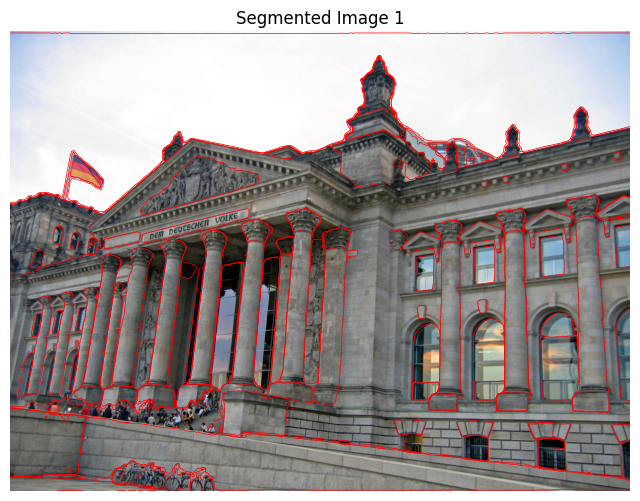

In [ ]:
# Visualize segmented image
visualize_segmented_image(image1, masks1, "Segmented Image 1")

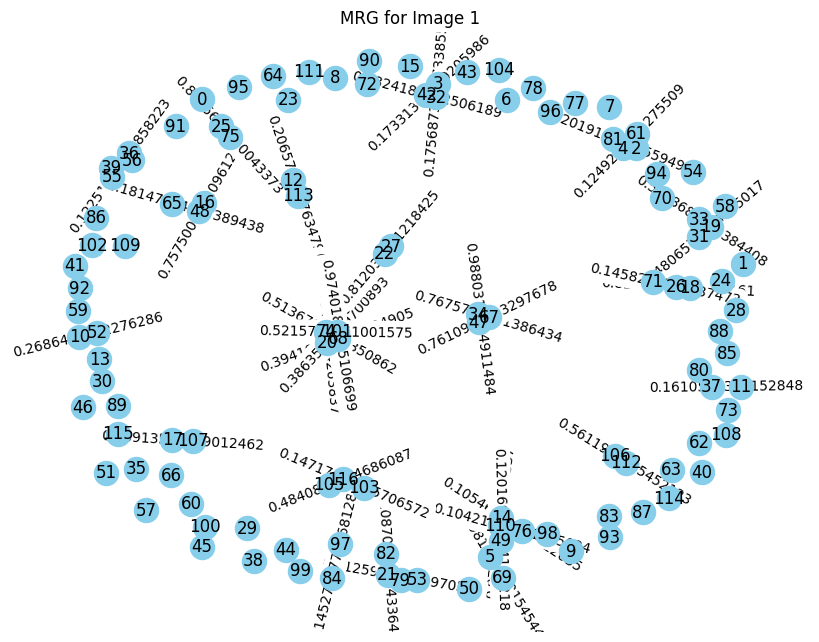

In [ ]:
visualize_graph(area_graph1, "MRG for Image 1")

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
<ipython-input-6-0273f9efe3fb>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Normalized Depth")


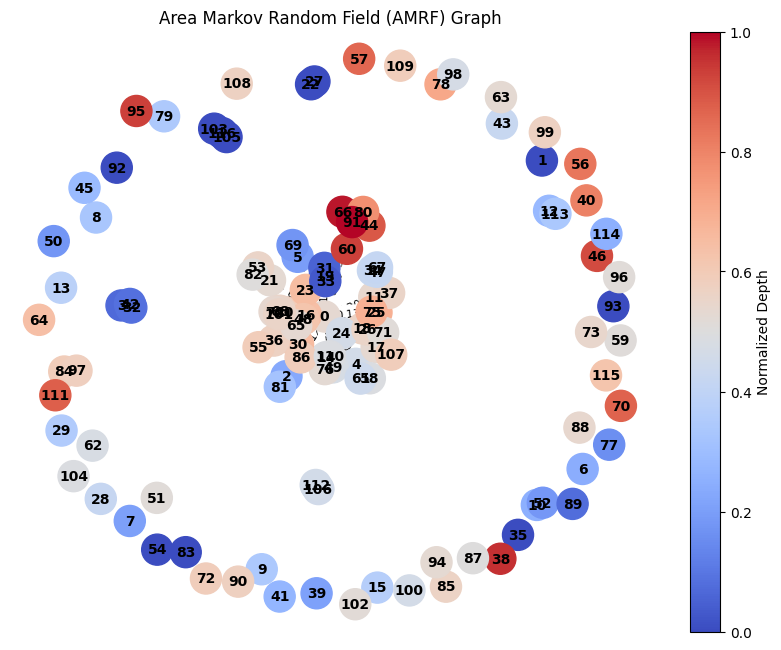

In [ ]:
visualize_amrf(amrf_graph1)

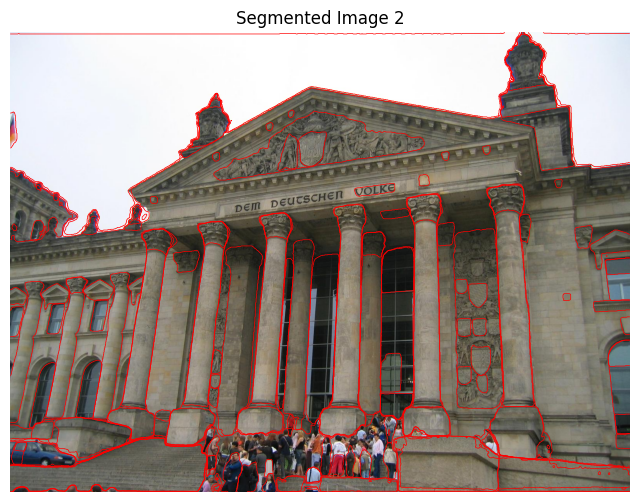

In [ ]:
# Visualize segmented image
visualize_segmented_image(image2, masks2, "Segmented Image 2")

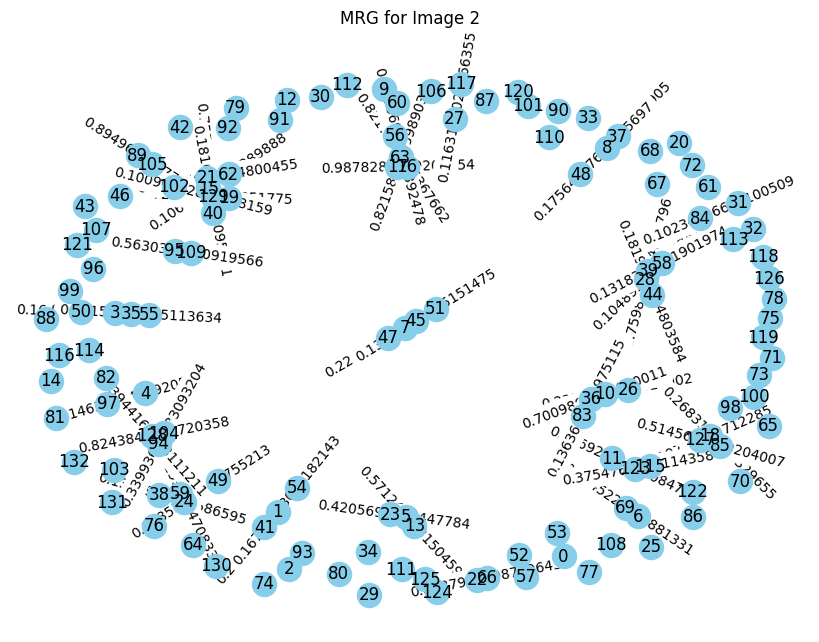

In [ ]:
visualize_graph(area_graph2, "MRG for Image 2")

<ipython-input-6-0273f9efe3fb>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Normalized Depth")


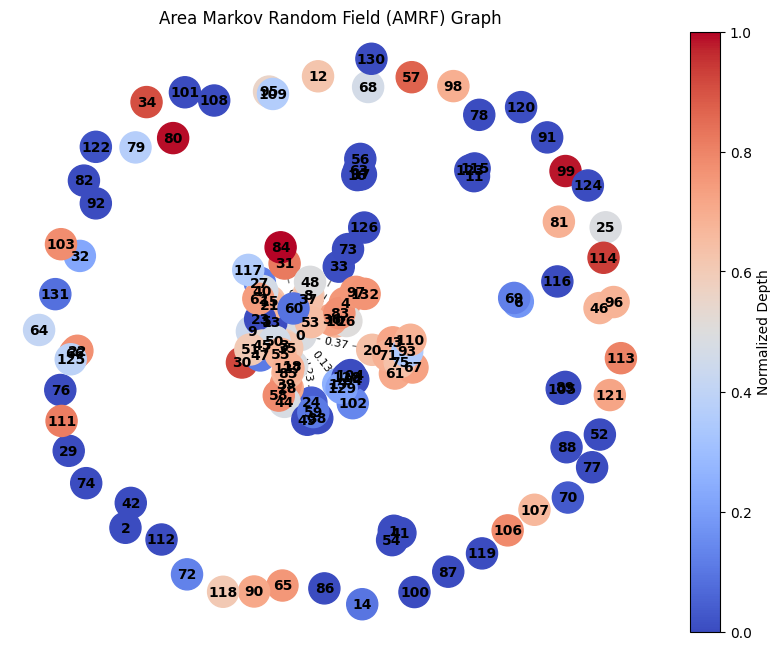

In [ ]:
visualize_amrf(amrf_graph2)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_cut(G, matched_areas, title="Graph Cut Result"):
    """
    Visualizes the AMRF graph after applying Graph Cut.
    Matched areas are highlighted in green, unmatched areas in red.
    """
    pos = nx.spring_layout(G)  # Position nodes in a visually clear layout
    plt.figure(figsize=(8, 6))

    # Color nodes based on whether they were matched
    node_colors = ["green" if node in matched_areas else "red" for node in G.nodes]

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, edge_color="gray")

    # Add edge weights as labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title)
    plt.show()

In [ ]:
print(f"Segments in Image 1: {len(masks1)}, Segments in Image 2: {len(masks2)}")

Segments in Image 1: 117, Segments in Image 2: 133


In [ ]:
print("Number of Matched Areas:", len(matched_areas))

Number of Matched Areas: 15561


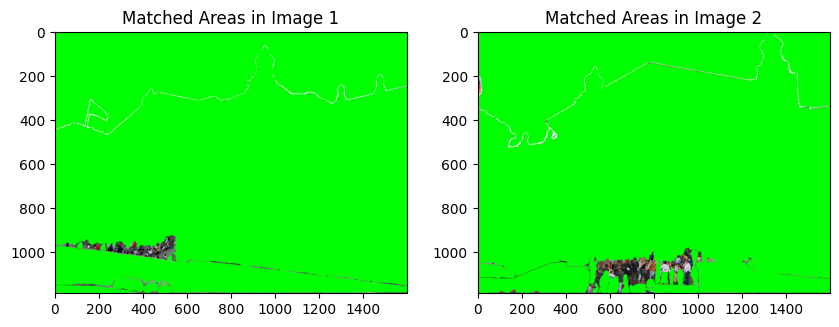

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def highlight_matched_regions(image, masks, matched_areas):
    """
    Highlights matched regions on the original image.
    """
    highlighted_image = image.copy()

    for idx, mask in enumerate(masks):
        if idx in matched_areas:  # If the segment is matched
            highlighted_image[mask["segmentation"]] = [0, 255, 0]  # Highlight in green

    return highlighted_image

# Highlight the matched areas in both images
highlighted_image1 = highlight_matched_regions(image1, masks1, [pair[0] for pair in matched_areas])
highlighted_image2 = highlight_matched_regions(image2, masks2, [pair[1] for pair in matched_areas])

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(highlighted_image1)
plt.title("Matched Areas in Image 1")

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image2)
plt.title("Matched Areas in Image 2")

plt.show()


Highlights matched regions in green.

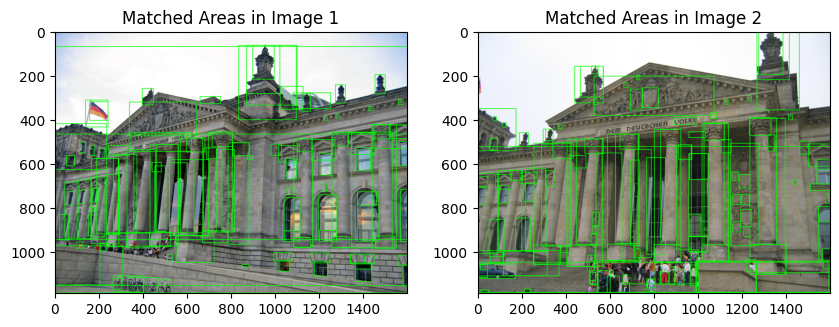

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_boxes(image, masks, matched_areas):
    """
    Draws bounding boxes around matched regions on the original image.
    """
    highlighted_image = image.copy()

    for idx, mask in enumerate(masks):
        if idx in matched_areas:  # If the segment is matched
            # Convert the mask to a binary mask (if it's a boolean mask)
            binary_mask = mask["segmentation"].astype(np.uint8) * 255
            # Get the bounding box of the region
            x, y, w, h = cv2.boundingRect(binary_mask)
            # Draw the bounding box in green
            cv2.rectangle(highlighted_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return highlighted_image

# Draw bounding boxes around the matched areas in both images
highlighted_image1 = draw_bounding_boxes(image1, masks1, [pair[0] for pair in matched_areas])
highlighted_image2 = draw_bounding_boxes(image2, masks2, [pair[1] for pair in matched_areas])

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(highlighted_image1)
plt.title("Matched Areas in Image 1")

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image2)
plt.title("Matched Areas in Image 2")

plt.show()


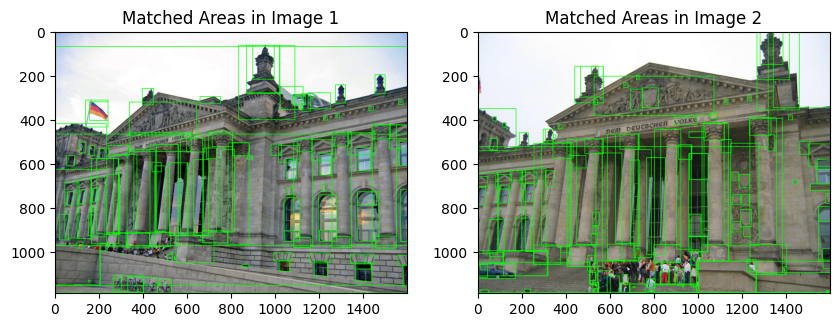

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_boxes(image, masks, matched_areas):
    """
    Draws bounding boxes around matched regions on the original image.
    """
    highlighted_image = image.copy()

    for idx, mask in enumerate(masks):
        if idx in matched_areas:  # If the segment is matched
            # Convert the mask to a binary mask (if it's a boolean mask)
            binary_mask = mask["segmentation"].astype(np.uint8) * 255
            # Find contours from the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if cv2.contourArea(contour) > 0:  # Ensure the contour area is valid
                    # Get the bounding box of the region
                    x, y, w, h = cv2.boundingRect(contour)
                    # Draw the bounding box in green
                    cv2.rectangle(highlighted_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return highlighted_image

# Draw bounding boxes around the matched areas in both images
highlighted_image1 = draw_bounding_boxes(image1, masks1, [pair[0] for pair in matched_areas])
highlighted_image2 = draw_bounding_boxes(image2, masks2, [pair[1] for pair in matched_areas])

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(highlighted_image1)
plt.title("Matched Areas in Image 1")

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image2)
plt.title("Matched Areas in Image 2")

plt.show()


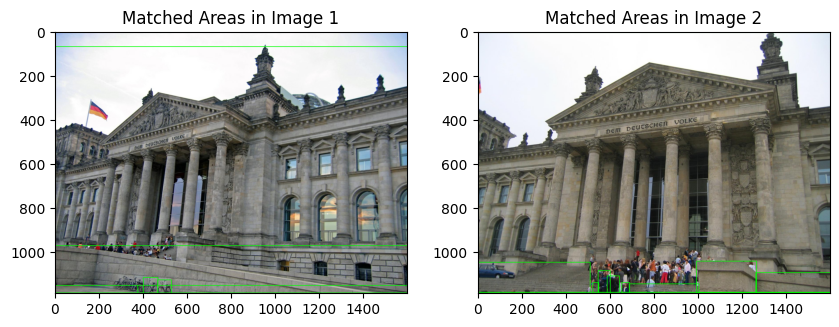

In [ ]:
# With NMS

import cv2
import numpy as np
import matplotlib.pyplot as plt

def non_max_suppression(bboxes, overlapThresh=0.3):
    """
    Apply Non-Maximum Suppression to remove redundant bounding boxes.
    """
    if len(bboxes) == 0:
        return []

    # Convert to float for NMS
    bboxes = np.array(bboxes)
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    # Compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the bounding boxes by the bottom-right y-coordinate
    idxs = np.argsort(y2)

    pick = []

    while len(idxs) > 0:
        # Grab the last box in the indexes list and add it to the list of picked boxes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find all boxes that overlap with the picked box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the overlap box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all boxes that have a high overlap with the picked box
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return the picked bounding boxes
    return bboxes[pick].astype(int)

def draw_bounding_boxes(image, masks, matched_areas, nms_threshold=0.3):
    """
    Draws bounding boxes around matched regions on the original image with NMS applied.
    """
    highlighted_image = image.copy()
    bboxes = []

    for idx, mask in enumerate(masks):
        if idx in matched_areas:  # If the segment is matched
            # Convert the mask to a binary mask (if it's a boolean mask)
            binary_mask = mask["segmentation"].astype(np.uint8) * 255
            # Find contours from the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if cv2.contourArea(contour) > 0:  # Ensure the contour area is valid
                    # Get the bounding box of the region
                    x, y, w, h = cv2.boundingRect(contour)
                    bboxes.append([x, y, x + w, y + h])  # Store the coordinates of bounding box

    # Apply Non-Maximum Suppression to remove redundant boxes
    if bboxes:
        bboxes = non_max_suppression(bboxes, overlapThresh=nms_threshold)

        # Draw the bounding boxes in green
        for (x1, y1, x2, y2) in bboxes:
            cv2.rectangle(highlighted_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return highlighted_image

# Draw bounding boxes around the matched areas in both images with NMS
highlighted_image1 = draw_bounding_boxes(image1, masks1, [pair[0] for pair in matched_areas])
highlighted_image2 = draw_bounding_boxes(image2, masks2, [pair[1] for pair in matched_areas])

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(highlighted_image1)
plt.title("Matched Areas in Image 1")

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image2)
plt.title("Matched Areas in Image 2")

plt.show()


# Step 5: Learning area similarity using Siamese network

In [ ]:
# optimised siamese network
# with batch normalisation, dropout and Smaller Feature Map

import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedSiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):
        super(OptimizedSiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Norm speeds up convergence
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((4, 4))  # Reducing final feature size for efficiency
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512, 128)  # Smaller embedding size for efficiency
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)  # Keep dim for easy FC processing
        return distance


# Generating pairs

In [ ]:
# steps to generate pairs

import os
import random

dataset_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2"
output_pairs_file = "pairs.txt"

scenes = sorted(os.listdir(dataset_path))

pairs = []

for scene in scenes:
    scene_path = os.path.join(dataset_path, scene, "dense0", "imgs")
    if not os.path.exists(scene_path):
        continue

    images = sorted(os.listdir(scene_path))

    # Create positive pairs (same scene)
    for _ in range(len(images) // 2):
        img1, img2 = random.sample(images, 2)
        pairs.append(f"{scene}/dense0/imgs/{img1} {scene}/dense0/imgs/{img2} 1")

# Create negative pairs (different scenes)
all_images = []
scene_map = {}
for scene in scenes:
    scene_path = os.path.join(dataset_path, scene, "dense0", "imgs")
    if not os.path.exists(scene_path):
        continue
    scene_images = sorted(os.listdir(scene_path))
    scene_map[scene] = scene_images
    for img in scene_images:
        all_images.append((scene, img))

for _ in range(len(all_images) // 2):
    (scene1, img1), (scene2, img2) = random.sample(all_images, 2)
    if scene1 != scene2:
        pairs.append(f"{scene1}/dense0/imgs/{img1} {scene2}/dense0/imgs/{img2} 0")

# Save pairs to file
with open(output_pairs_file, "w") as f:
    f.write("\n".join(pairs))

print(f"Generated {len(pairs)} pairs and saved to {output_pairs_file}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Define Contrastive Loss
def contrastive_loss(distance, label, margin=1.0):
    loss = label * torch.pow(distance, 2) + (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return torch.mean(loss)

# Define Siamese Dataset that uses pairs.txt
class SiameseDataset(Dataset):
    def __init__(self, pairs_file, root_folder, transform=None):
        self.pairs = []
        self.root_folder = root_folder
        self.transform = transform

        with open(pairs_file, "r") as f:
            for line in f:
                img1, img2, label = line.strip().split()
                self.pairs.append((img1, img2, int(label)))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        img1 = Image.open(os.path.join(self.root_folder, img1_path)).convert("L")
        img2 = Image.open(os.path.join(self.root_folder, img2_path)).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([float(label)], dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((400, 296)),
    transforms.ToTensor()
])


# Training siamese network

In [ ]:
# Load dataset from pairs.txt
dataset = SiameseDataset("pairs.txt", "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2", transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=8)

# Load Siamese Model
model = OptimizedSiameseNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

print("Training Complete!")

> Verifying siamese on 2 images

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import os

model = OptimizedSiameseNetwork()

# Load the trained model
model.eval()

# Define a function to test two images
def test_siamese(img1_path, img2_path, model, transform, device):

    # convert("L") converts the images to grayscale (1 channel)
    img1 = Image.open(img1_path).convert("L")
    img2 = Image.open(img2_path).convert("L")

    # .unsqueeze(0) adds a batch dimension → Converts shape from [C, H, W] to [1, C, H, W] (needed for model input)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)

    # torch.no_grad() disables gradient calculation (saves memory & speeds up inference).
    with torch.no_grad():
        distance = model(img1, img2)

    print(f"Distance between images: {distance.item():.4f}")
    return distance.item()

# Sample image paths from the dataset
sample_img1 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg"
sample_img2 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1125352430_fa4e56275f_o.jpg"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = model.to(device)
# model.load_state_dict(torch.load("siamese_model.pth", map_location=device))
# model.eval()

# Run test
test_siamese(sample_img1, sample_img2, model, transform, device)


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load images
image1 = cv2.imread('/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB

image2 = cv2.imread('/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1125352430_fa4e56275f_o.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Image 2")
plt.axis("off")

plt.show()


# Bounding Box

In [ ]:
import matplotlib.pyplot as plt

def show_images_side_by_side(img1, img2, distance=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title("Image 1")
    axs[0].axis("off")

    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title("Image 2")
    axs[1].axis("off")

    if distance is not None:
        plt.suptitle(f"Siamese Distance: {distance:.4f}", fontsize=14)

    plt.tight_layout()
    plt.show()


In [ ]:
from PIL import ImageDraw

def draw_bounding_boxes_with_matches_nonmatches(image, amrf_graph, matched_indices, is_image1=True):
    """
    Draw bounding boxes for matched and unmatched regions on the image.

    Args:
        image (PIL.Image): The original grayscale image.
        amrf_graph (nx.Graph): Graph containing masks in its nodes.
        matched_indices (list of tuples): List of (i, j) pairs of matched nodes.
        is_image1 (bool): True if this is for image 1, else for image 2.
    Returns:
        PIL.Image: Image with drawn bounding boxes.
    """
    img = image.convert("RGB")
    draw = ImageDraw.Draw(img)

    # Get all node indices in this graph
    all_nodes = set(amrf_graph.nodes)

    # Get matched node indices
    matched_nodes = {i for i, j in matched_indices} if is_image1 else {j for i, j in matched_indices}

    for node_idx in all_nodes:
        mask = amrf_graph.nodes[node_idx]["mask"]
        coords = np.argwhere(mask)
        if coords.size == 0:
            continue
        top_left = tuple(coords.min(axis=0)[::-1])
        bottom_right = tuple(coords.max(axis=0)[::-1])

        # Green if matched, red otherwise
        color = "green" if node_idx in matched_nodes else "red"
        draw.rectangle([top_left, bottom_right], outline=color, width=2)

    return img


In [ ]:
# img1 and img2: original grayscale PIL images
# amrf_graph1 and amrf_graph2: corresponding graphs
# matched_areas: output from graph cut [(i, j), ...]

# Draw bounding boxes for each image
img1_with_boxes = draw_bounding_boxes_with_matches_nonmatches(img1, amrf_graph1, matched_areas, is_image1=True)
img2_with_boxes = draw_bounding_boxes_with_matches_nonmatches(img2, amrf_graph2, matched_areas, is_image1=False)

# Show side by side with distance if Siamese was used
show_images_side_by_side(img1_with_boxes, img2_with_boxes, distance)


# Step 6: Area Bayesian Nwtwork

In [ ]:
def extract_features(graph):
    features = {}
    for node in graph.nodes:
        node_data = graph.nodes[node]
        features[node] = {
            "depth_mean": node_data.get("depth_mean", 0),
            "area": node_data["mask"].sum(),
            # Add texture, histogram, etc. if needed
        }
    return features


In [ ]:
def prepare_bayes_dataset(G1, G2, matched_areas):
    features1 = extract_features(G1)
    features2 = extract_features(G2)
    dataset = []

    matched_set = set(matched_areas)
    for i in G1.nodes:
        for j in G2.nodes:
            label = 1 if (i, j) in matched_set else 0
            f1 = features1[i]
            f2 = features2[j]
            sample = {
                "depth_diff": abs(f1["depth_mean"] - f2["depth_mean"]),
                "area_ratio": min(f1["area"], f2["area"]) / max(f1["area"], f2["area"]),
                "match": label
            }
            dataset.append(sample)
    return dataset


In [ ]:
!pip install pgmpy

In [ ]:
def train_bayes_model(dataset):
    df = pd.DataFrame(dataset)
    model = DiscreteBayesianNetwork([('depth_diff', 'match'), ('area_ratio', 'match')])
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    infer = VariableElimination(model)
    return model, infer

In [ ]:
def predict_matches_bayes(G1, G2, infer, threshold=0.5):
    predictions = []
    features1 = extract_features(G1)
    features2 = extract_features(G2)

    for i in G1.nodes:
        for j in G2.nodes:
            dd = abs(features1[i]["depth_mean"] - features2[j]["depth_mean"])
            ar = min(features1[i]["area"], features2[j]["area"]) / max(features1[i]["area"], features2[j]["area"])
            prob = infer.query(variables=['match'], evidence={'depth_diff': dd, 'area_ratio': ar})
            p_match = prob.values[1]
            if p_match > threshold:
                predictions.append((i, j))
    return predictions

In [ ]:
def draw_bounding_boxes(image, graph, matched_nodes, color=(0, 255, 0)):
    img = image.copy()
    for i in graph.nodes:
        mask = graph.nodes[i]["mask"].astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            x, y, w, h = cv2.boundingRect(contours[0])
            if i in matched_nodes:
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            else:
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red for unmatched
    return img

In [ ]:
# ---- Full Pipeline to Run and Visualize ---- #
def run_bayes_pipeline(img1_np, img2_np, amrf_graph1, amrf_graph2, matched_areas):
    dataset = prepare_bayes_dataset(amrf_graph1, amrf_graph2, matched_areas)
    model, infer = train_bayes_model(dataset)
    predictions = predict_matches_bayes(amrf_graph1, amrf_graph2, infer)

    # Extract matched nodes for each image
    matched1 = [i for (i, j) in predictions]
    matched2 = [j for (i, j) in predictions]

    out_img1 = draw_bounding_boxes(img1_np, amrf_graph1, matched1)
    out_img2 = draw_bounding_boxes(img2_np, amrf_graph2, matched2)

    # Display both
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].imshow(out_img1)
    axs[0].set_title("Bayesian Predicted Matches - Image 1")
    axs[1].imshow(out_img2)
    axs[1].set_title("Bayesian Predicted Matches - Image 2")
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# import pandas as pd
# from pgmpy.models import DiscreteBayesianNetwork
# from pgmpy.estimators import MaximumLikelihoodEstimator
# from pgmpy.inference import VariableElimination

# #Ensure input images are loaded as NumPy arrays:
# img1_np = np.array(Image.open(image1_path).convert("RGB"))
# img2_np = np.array(Image.open(image2_path).convert("RGB"))

# run_bayes_pipeline(img1_np, img2_np, amrf_graph1, amrf_graph2, matched_areas)

> Method 2: Area Bayesian Network

In [ ]:
import numpy as np
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# --- Step 1: Prepare the Bayesian dataset from matched areas ---
def prepare_bayes_dataset(G1, G2, matched_areas):
    data = []
    for i, j in matched_areas:
        depth1, depth2 = G1.nodes[i]['depth_mean'], G2.nodes[j]['depth_mean']
        area1, area2 = G1.nodes[i]['area'], G2.nodes[j]['area']

        depth_diff = abs(depth1 - depth2)
        area_ratio = min(area1, area2) / max(area1, area2)

        data.append({
            'depth_diff': round(depth_diff, 1),
            'area_ratio': round(area_ratio, 1),
            'match': 1
        })

    print("📦 Bayes Training Dataset:")
    for row in data:
        print(row)

    return data

# --- Step 2: Train Bayesian model from matched pairs ---
def train_bayes_model(data):
    df = pd.DataFrame(data)

    # Discretize features into bins if necessary
    if not df.empty:
        model = DiscreteBayesianNetwork([('depth_diff', 'match'), ('area_ratio', 'match')])
        model.fit(df, estimator=MaximumLikelihoodEstimator)
        infer = VariableElimination(model)
        return model, infer
    else:
        raise ValueError("No matched areas provided for Bayesian training.")

def predict_matches_bayes(G1, G2, infer, threshold=0.5):
    predicted_matches = []

    for i in G1.nodes:
        for j in G2.nodes:
            depth_diff = abs(G1.nodes[i]['depth_mean'] - G2.nodes[j]['depth_mean'])
            area1 = G1.nodes[i]['area']
            area2 = G2.nodes[j]['area']
            area_ratio = min(area1, area2) / max(area1, area2)

            evidence = {
                'depth_diff': round(depth_diff, 1),
                'area_ratio': round(area_ratio, 1)
            }

            try:
                prob = infer.query(variables=['match'], evidence=evidence)
                match_prob = prob.values[1]
                print(f"✅ Predicted: G1 node {i} ↔ G2 node {j} | Evidence: {evidence} | Match Probability: {match_prob:.2f}")
                if match_prob >= threshold:
                    predicted_matches.append((i, j, match_prob))
            except Exception as e:
                print(f"⚠️ Skipping: G1 node {i} ↔ G2 node {j} | Evidence: {evidence} | Reason: {e}")

    return predicted_matches

def run_bayes_pipeline(G1, G2, matched_areas, threshold=0.5):
    dataset = prepare_bayes_dataset(G1, G2, matched_areas)
    model, infer = train_bayes_model(dataset)
    predicted_matches = predict_matches_bayes(G1, G2, infer, threshold=threshold)

    print("\n🎯 Final Predicted Matches (with probability ≥ threshold):")
    if not predicted_matches:
        print("🚫 No matches found above threshold.")
    for i, j, prob in predicted_matches:
        print(f"Region {i} ↔ Region {j}  |  Match Probability: {prob:.2f}")

    return predicted_matches


In [ ]:
def add_area_to_graph_nodes(G):
    for node in G.nodes:
        mask = G.nodes[node].get("mask", None)
        if mask is not None:
            G.nodes[node]["area"] = int(np.sum(mask))  # Area = number of non-zero pixels
        else:
            G.nodes[node]["area"] = 0

# Apply to both graphs
add_area_to_graph_nodes(amrf_graph1)
add_area_to_graph_nodes(amrf_graph2)


In [ ]:
# Assuming you already have:
# - amrf_graph1, amrf_graph2
# - matched_areas from Graph Cut or Siamese Matching

predicted_matches = run_bayes_pipeline(amrf_graph1, amrf_graph2, matched_areas)

# Graph Energy Calculation

In [ ]:
import numpy as np
import networkx as nx
import torch

def compute_graph_energy(similarity_matrix):
    """
    Computes the graph energy from the given similarity matrix.
    :param similarity_matrix: NxN matrix representing pairwise similarities (adjacency matrix)
    :return: Graph energy value
    """
    # Convert similarity matrix to adjacency matrix (ensure symmetry)
    adjacency_matrix = (similarity_matrix + similarity_matrix.T) / 2

    # Construct graph from adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)

    # Compute eigenvalues of adjacency matrix
    eigenvalues = np.linalg.eigvals(nx.to_numpy_array(G))

    # Compute graph energy
    graph_energy = np.sum(np.abs(eigenvalues))

    return graph_energy

# Example: Generate similarity matrix from Siamese outputs
def generate_similarity_matrix(model, dataset, device="cpu"):
    """
    Uses the Siamese network to generate a similarity matrix for graph energy computation.
    :param model: Trained Siamese Network
    :param dataset: List of image tensors
    :param device: Computation device (CPU/GPU)
    :return: NxN similarity matrix
    """
    model.eval()
    num_samples = len(dataset)
    similarity_matrix = np.zeros((num_samples, num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            for j in range(num_samples):
                if i != j:
                    img1, img2 = dataset[i].unsqueeze(0).to(device), dataset[j].unsqueeze(0).to(device)
                    distance = model(img1, img2)
                    similarity_matrix[i, j] = 1 / (1 + distance.item())  # Convert distance to similarity

    return similarity_matrix

# Example Usage:
# dataset = [...]  # Load dataset as tensors
# similarity_matrix = generate_similarity_matrix(siamese_model, dataset)
# graph_energy = compute_graph_energy(similarity_matrix)
# print(f"Graph Energy: {graph_energy}")


# Matched and unmatched areas

In [ ]:
import networkx as nx

def get_matched_unmatched_areas(G):
    """Returns matched and unmatched areas from the Multi-Relational Graph (MRG)."""
    matched_areas = []
    unmatched_areas = []

    # Find connected components (groups of connected nodes)
    components = list(nx.connected_components(G))

    for component in components:
        if len(component) > 1:  # If more than 1 node, it's a matched area
            matched_areas.append(component)
        else:  # Single node means no match (unmatched)
            unmatched_areas.append(list(component)[0])

    return matched_areas, unmatched_areas

# Example usage
matched, unmatched = get_matched_unmatched_areas(area_graph)

print(f"Matched Areas (Connected Groups): {matched}")
print(f"Unmatched Areas (Isolated Nodes): {unmatched}")

# Hierarchical Graph

In [ ]:
import networkx as nx

def build_hierarchy(G, masks): # Add masks to the function parameters
    """Constructs a hierarchical structure from MRG by clustering related areas."""
    hierarchy = nx.Graph()

    # Merge nodes with high connectivity (strong matches)
    clusters = list(nx.connected_components(G))

    for cluster_id, nodes in enumerate(clusters):
        hierarchy.add_node(cluster_id, members=list(nodes))

    # Connect clusters based on proximity (e.g., depth similarity)
    for i, cluster_i in enumerate(clusters):
        for j, cluster_j in enumerate(clusters):
            if i != j:
                # Compute similarity based on average depth difference
                # Access depth_mean from masks using node indices
                depth_diff = np.abs(np.mean([masks[n]['depth_mean'] for n in cluster_i]) -
                                    np.mean([masks[n]['depth_mean'] for n in cluster_j]))

                if depth_diff < 0.5:  # Adjust threshold
                    hierarchy.add_edge(i, j, weight=np.exp(-depth_diff))

    return hierarchy

# Call build_hierarchy with both area_graph and masks
hierarchy_graph = build_hierarchy(area_graph, masks)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Option 1: Visualize with NetworkX (if you have matplotlib installed)
def visualize_hierarchy_graph(hierarchy_graph):
    """Visualizes the hierarchy graph."""
    pos = nx.spring_layout(hierarchy_graph)
    nx.draw(hierarchy_graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8)
    edge_labels = nx.get_edge_attributes(hierarchy_graph, "weight")
    nx.draw_networkx_edge_labels(hierarchy_graph, pos, edge_labels=edge_labels)
    plt.title("Hierarchy Graph")
    plt.show()

visualize_hierarchy_graph(hierarchy_graph)

# Option 2: Print nodes and edges
print("Nodes:", hierarchy_graph.nodes(data=True))  # Prints nodes and their attributes
print("Edges:", hierarchy_graph.edges(data=True))  # Prints edges and their attributes

# Energy Matching

In [ ]:
import networkx as nx
import numpy as np

def compute_matching_energy(G, masks):
    """Computes an array of energy values for area matching instead of a single scalar."""
    energy_values = []  # Store energy per edge

    for u, v, attr in G.edges(data=True):
        iou = attr['weight']  # IoU as weight

        # Access depth_mean from masks using node indices (u, v)
        depth_diff = np.abs(masks[u]['depth_mean'] - masks[v]['depth_mean'])

        # Compute energy for this pair
        energy = iou * np.exp(-depth_diff)
        energy_values.append(energy)

    return np.array(energy_values)  # Return an array instead of a single sum


# Call compute_matching_energy with area_graph and masks
matching_energy = compute_matching_energy(area_graph, masks)
print(f"Total Matching Energy before normalization: {matching_energy.sum():.4f}")

"""matching_energy = normalize_matching_energy(matching_energy)
print("Matching energy after normalization:", matching_energy.sum())
"""

In [ ]:
print(np.unique(matching_energy))  # Check unique values


# Visualise final matches within a single image

In [ ]:
import matplotlib.pyplot as plt
import cv2

def visualize_final_matches(image, masks, matched, unmatched):
    plt.imshow(image)

    for match in matched:
        for idx in match:
            mask = masks[idx]["segmentation"]
            plt.contour(mask, colors="g", linewidths=1)  # Green for matched

    for idx in unmatched:
        mask = masks[idx]["segmentation"]
        plt.contour(mask, colors="r", linewidths=1)  # Red for unmatched

    plt.title("Final Area Matching")
    plt.show()

visualize_final_matches(image, masks, matched, unmatched)

# Matching Between two images

In [ ]:
import cv2
import matplotlib.pyplot as plt

# to visualise two images: img1 and img2 passed below
def visualize_two_images(image1, image2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1)
    axs[0].set_title('Image 1')
    axs[1].imshow(image2)
    axs[1].set_title('Image 2')
    plt.show()

In [ ]:
image1 = cv2.imread('/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Convert to RGB

image2 = cv2.imread('/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1125352430_fa4e56275f_o.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)  # Convert to RGB

visualize_two_images(image1, image2)

In [ ]:
import numpy as np

def match_areas_between_images(masks_A, masks_B):
    """Matches areas between two images based on IoU & depth similarity."""
    matches = []
    unmatched_A = set(range(len(masks_A)))
    unmatched_B = set(range(len(masks_B)))

    for i, mask_A in enumerate(masks_A):
        best_match = None
        best_score = 0

        for j, mask_B in enumerate(masks_B):
            # Ensure segmentation masks are in the same shape
            shape_A = mask_A["segmentation"].shape
            shape_B = mask_B["segmentation"].shape

            if shape_A != shape_B:
                max_shape = (max(shape_A[0], shape_B[0]), max(shape_A[1], shape_B[1]))

                mask_A_padded = np.pad(mask_A["segmentation"],
                                       ((0, max_shape[0] - shape_A[0]), (0, max_shape[1] - shape_A[1])),
                                       mode='constant', constant_values=0)
                mask_B_padded = np.pad(mask_B["segmentation"],
                                       ((0, max_shape[0] - shape_B[0]), (0, max_shape[1] - shape_B[1])),
                                       mode='constant', constant_values=0)
            else:
                mask_A_padded = mask_A["segmentation"]
                mask_B_padded = mask_B["segmentation"]

            # Compute IoU (Intersection over Union)
            intersection = np.logical_and(mask_A_padded, mask_B_padded).sum()
            union = np.logical_or(mask_A_padded, mask_B_padded).sum()
            iou = intersection / union if union > 0 else 0  # Avoid division by zero

            # Compute depth difference (use default 0 if key is missing)
            depth_A = mask_A.get("depth_mean", 0)
            depth_B = mask_B.get("depth_mean", 0)
            depth_diff = np.abs(depth_A - depth_B)

            # Compute final matching score
            score = iou * np.exp(-depth_diff)  # Higher = better match

            if score > best_score:
                best_score = score
                best_match = j

        if best_match is not None and best_score > 0.2:  # Threshold
            matches.append((i, best_match, best_score))
            unmatched_A.discard(i)
            unmatched_B.discard(best_match)

    return matches, unmatched_A, unmatched_B

In [ ]:
matches, unmatched_A, unmatched_B = match_areas_between_images(masks_img1, masks_img2)

print(f"Matched Areas: {matches}")
print(f"Unmatched Areas in Image A: {unmatched_A}")
print(f"Unmatched Areas in Image B: {unmatched_B}")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_matches(image_A, image_B, masks_A, masks_B, matches, unmatched_A, unmatched_B):
    """Visualizes matched and unmatched segmentation areas on two images."""

    # Convert images to RGB if needed
    if len(image_A.shape) == 2:  # Grayscale to RGB
        image_A = cv2.cvtColor(image_A, cv2.COLOR_GRAY2RGB)
    if len(image_B.shape) == 2:
        image_B = cv2.cvtColor(image_B, cv2.COLOR_GRAY2RGB)

    overlay_A = image_A.copy()
    overlay_B = image_B.copy()

    # Generate random colors for each matched pair
    match_colors = {idx: (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for idx, _, _ in matches}

    # Draw matched areas
    for idx_A, idx_B, _ in matches:
        color = match_colors[idx_A]  # Same color for both masks
        mask_A = masks_A[idx_A]["segmentation"]
        mask_B = masks_B[idx_B]["segmentation"]

        overlay_A[mask_A > 0] = overlay_A[mask_A > 0] * 0.5 + np.array(color) * 0.5
        overlay_B[mask_B > 0] = overlay_B[mask_B > 0] * 0.5 + np.array(color) * 0.5

    # Draw unmatched areas in red
    for idx in unmatched_A:
        mask_A = masks_A[idx]["segmentation"]
        overlay_A[mask_A > 0] = overlay_A[mask_A > 0] * 0.5 + np.array([255, 0, 0]) * 0.5  # Red for unmatched

    for idx in unmatched_B:
        mask_B = masks_B[idx]["segmentation"]
        overlay_B[mask_B > 0] = overlay_B[mask_B > 0] * 0.5 + np.array([255, 0, 0]) * 0.5  # Red for unmatched

    # Plot images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(overlay_A.astype(np.uint8))
    plt.title("Image A with Matched & Unmatched Areas")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_B.astype(np.uint8))
    plt.title("Image B with Matched & Unmatched Areas")

    plt.show()


In [ ]:
visualize_matches(image1, image2, masks_img1, masks_img2, matches, unmatched_A, unmatched_B)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def draw_bounding_boxes(image, masks, matched_indices, unmatched_indices, color):
    """Draw bounding boxes around masks."""
    image_with_boxes = image.copy()

    for idx in matched_indices:
        mask = masks[idx]["segmentation"].astype(np.uint8) * 255
        x, y, w, h = cv2.boundingRect(mask)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 3)  # Green for matched

    for idx in unmatched_indices:
        mask = masks[idx]["segmentation"].astype(np.uint8) * 255
        x, y, w, h = cv2.boundingRect(mask)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Red for unmatched

    return image_with_boxes

def visualize_matches2(image_A, image_B, masks_A, masks_B, matches, unmatched_A, unmatched_B):
    """Visualizes matched and unmatched areas with bounding boxes."""

    # Convert grayscale images to RGB if needed
    if len(image_A.shape) == 2:
        image_A = cv2.cvtColor(image_A, cv2.COLOR_GRAY2RGB)
    if len(image_B.shape) == 2:
        image_B = cv2.cvtColor(image_B, cv2.COLOR_GRAY2RGB)

    # Create a list of matched indices
    matched_A = [m[0] for m in matches]
    matched_B = [m[1] for m in matches]

    # Draw bounding boxes
    image_A_with_boxes = draw_bounding_boxes(image_A, masks_A, matched_A, unmatched_A, (0, 255, 0))  # Green for matched
    image_B_with_boxes = draw_bounding_boxes(image_B, masks_B, matched_B, unmatched_B, (0, 255, 0))  # Green for matched

    # Plot images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_A_with_boxes)
    plt.title("Image A with Bounding Boxes")

    plt.subplot(1, 2, 2)
    plt.imshow(image_B_with_boxes)
    plt.title("Image B with Bounding Boxes")

    plt.show()

In [ ]:
visualize_matches2(image1, image2, masks_img1, masks_img2, matches, unmatched_A, unmatched_B)

# **Method 2: MESA**

In [ ]:
import os
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from bayes_opt import BayesianOptimization
import h5py

In [ ]:
!pip install segment_anything

In [ ]:
# ----------------------------
# 1. Load MegaDepth Dataset
# ----------------------------
def load_megadepth_data(dataset_path):
    image_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])
    depth_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.h5')])
    return image_files, depth_files

# ----------------------------
# 2. Load Image and Depth Map
# ----------------------------
def load_megadepth_image(image_path, depth_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    depth = np.load(depth_path)  # Ensure depth is in .npy format
    return image, depth

# Segmentation

In [ ]:
# ----------------------------
# 3. Initialize SAM for Segmentation
# ----------------------------
def initialize_sam(model_path):
    sam = sam_model_registry["vit_h"](checkpoint=model_path)
    return SamAutomaticMaskGenerator(sam)

# ----------------------------
# 4. Segment Image Using SAM
# ----------------------------
def segment_image(image, sam_mask_generator):
    masks = sam_mask_generator.generate(image)
    return masks

# MRG and AMRF

In [ ]:
import cv2
import numpy as np
import networkx as nx

def resize_mask(mask, target_shape):
    return cv2.resize(mask.astype(np.uint8), (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)

def construct_mrg_amrf1(masks):
    G = nx.Graph()

    # Find the reference shape (smallest height, width)
    min_h = min(mask["segmentation"].shape[0] for mask in masks)
    min_w = min(mask["segmentation"].shape[1] for mask in masks)
    target_shape = (min_h, min_w)

    for idx, mask in enumerate(masks):
        resized_mask = resize_mask(mask["segmentation"], target_shape)  # Resize mask
        depth_map = mask.get("depth_map", np.zeros_like(resized_mask))  # Use zero depth if missing
        depth_mean = np.mean(depth_map)  # Compute depth mean

        G.add_node(idx, mask=resized_mask, depth_mean=depth_mean)  # Store depth_mean in node attributes

    for i, mask_i in G.nodes(data=True):  # Access stored node attributes
        for j, mask_j in G.nodes(data=True):
            if i != j:
                seg_i = mask_i["mask"]
                seg_j = mask_j["mask"]

                intersection = np.logical_and(seg_i, seg_j).sum()
                union = np.logical_or(seg_i, seg_j).sum()

                iou = intersection / union if union != 0 else 0

                depth_diff = np.abs(mask_i["depth_mean"] - mask_j["depth_mean"])  # Use stored depth_mean
                confidence = (masks[i].get("predicted_iou", 0) + masks[j].get("predicted_iou", 0)) / 2
                weight = iou * np.exp(-depth_diff) * confidence

                if weight > 0.2:
                    G.add_edge(i, j, weight=weight)

    return G


# Siamese Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self, input_size=(32, 32)):  # Default input size
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size = input_size / 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size = input_size / 4
        )

        # Compute feature map size dynamically
        sample_input = torch.zeros(1, 1, *input_size)  # Batch size 1
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]  # Dynamically compute

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),  # Use computed size
            nn.ReLU(),
            nn.Linear(256, 128)  # Output embedding of size 128
        )
        self.fc_final = nn.Linear(1, 1)  # Fixed: Only 1 input (distance)

    def forward_once(self, x):
        x = self.cnn(x)
        print("CNN output shape:", x.shape)  # Debug
        x = x.view(x.size(0), -1)  # Flatten dynamically
        print("Flattened shape:", x.shape)  # Debug
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2)  # Compute Euclidean distance
        return self.fc_final(distance)  # Fixed: Now takes a single value


# Bayesian Optmisation

In [ ]:
# ----------------------------
# 7. Bayesian Optimization for Matching Threshold
# ----------------------------
def optimize_threshold(matches):
    def objective(threshold):
        return sum(1 for _, _, score in matches if score > threshold) / len(matches)
    optimizer = BayesianOptimization(f=objective, pbounds={'threshold': (0, 1)}, verbose=2)
    optimizer.maximize()
    return optimizer.max['params']['threshold']

In [ ]:
# ----------------------------
# 8. Train Siamese Network on Dataset
# ----------------------------
def train_siamese_network(dataset_path, model_save_path):
    siamese_model = SiameseNetwork()
    optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

    image_files, depth_files = load_megadepth_data(dataset_path)

    for img_file, depth_file in zip(image_files, depth_files):
        image, depth = load_megadepth_image(os.path.join(dataset_path, img_file), os.path.join(dataset_path, depth_file))
        sam_mask_generator = initialize_sam(model_path)
        masks = segment_image(image, sam_mask_generator)
        graph = construct_mrg_amrf(masks)  # AMRF-enhanced graph construction
        train_siamese(siamese_model, masks, optimizer)

    torch.save(siamese_model.state_dict(), model_save_path)
    return siamese_model

In [ ]:
# ----------------------------
# 9. Run Full Pipeline on MegaDepth
# ----------------------------
if __name__ == "__main__":
    dataset_path = "/kaggle/input/megadepth-v1-p4/"  # Update with your MegaDepth dataset path
    model_save_path = "siamese_model.pth"
    model_path = "/kaggle/input/sam/other/default/1"

    # Train and save Siamese Network
    siamese_model = train_siamese_network(dataset_path, model_save_path)

    # Load dataset images
    image_files, depth_files = load_megadepth_data(dataset_path)

    # Iterate over pairs for matching
    for i in range(len(image_files) - 1):
        image1, depth1 = load_megadepth_image(os.path.join(dataset_path, image_files[i]), os.path.join(dataset_path, depth_files[i]))
        image2, depth2 = load_megadepth_image(os.path.join(dataset_path, image_files[i + 1]), os.path.join(dataset_path, depth_files[i + 1]))
        sam_mask_generator = initialize_sam(model_path)
        masks_A = segment_image(image1, sam_mask_generator)
        masks_B = segment_image(image2, sam_mask_generator)
        matches, unmatched_A, unmatched_B = match_areas_siamese(masks_A, masks_B, siamese_model)
        threshold = optimize_threshold(matches)
        visualize_matched_areas(image1, image2, matches, unmatched_A, unmatched_B)

In [ ]:
def visualize_original_images(image1, image2, depth1, depth2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    axes[0, 0].imshow(image1)
    axes[0, 0].set_title("Image 1")

    axes[0, 1].imshow(image2)
    axes[0, 1].set_title("Image 2")

    axes[1, 0].imshow(depth1, cmap='gray')
    axes[1, 0].set_title("Depth Map 1")

    axes[1, 1].imshow(depth2, cmap='gray')
    axes[1, 1].set_title("Depth Map 2")

    plt.show()

In [ ]:
def visualize_segmentation(image, masks, title="Segmentation Masks"):
    segmented_image = image.copy()
    for mask in masks:
        segmented_image[mask["segmentation"]] = [0, 255, 0]  # Green for masks

    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_image)
    plt.title(title)
    plt.show()

In [ ]:
# MRG
def visualize_graph(G):
    plt.figure(figsize=(6, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
    plt.title("Multi-Relational Graph (MRG)")
    plt.show()

In [ ]:
import numpy as np
import torch

def match_areas_siamese(masks_A, masks_B, siamese_model, threshold=0.5):
    matches = []
    unmatched_A = set(range(len(masks_A)))
    unmatched_B = set(range(len(masks_B)))

    for i, mask_A in enumerate(masks_A):
        best_match = None
        best_score = float("inf")  # Lower distance is better in Siamese Networks

        for j, mask_B in enumerate(masks_B):
            # Convert masks into tensors and feed into Siamese Network
            mask_A_tensor = torch.tensor(mask_A["segmentation"], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            mask_B_tensor = torch.tensor(mask_B["segmentation"], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            with torch.no_grad():
                distance = siamese_model(mask_A_tensor, mask_B_tensor).item()  # Compute similarity score

            if distance < best_score:
                best_score = distance
                best_match = j

        if best_match is not None and best_score < threshold:
            matches.append((i, best_match, best_score))
            unmatched_A.discard(i)
            unmatched_B.discard(best_match)

    return matches, list(unmatched_A), list(unmatched_B)


In [ ]:
# matched and unmatched areas
def visualize_matched_areas(image1, image2, matches, unmatched_A, unmatched_B):
    image1_copy = image1.copy()
    image2_copy = image2.copy()

    for match in matches:
        i, j, score = match
        rect_A = cv2.boundingRect(np.array(np.where(image1_copy == i)).T)
        rect_B = cv2.boundingRect(np.array(np.where(image2_copy == j)).T)
        cv2.rectangle(image1_copy, rect_A, (0, 255, 0), 2)  # Green for matches
        cv2.rectangle(image2_copy, rect_B, (0, 255, 0), 2)

    for i in unmatched_A:
        rect_A = cv2.boundingRect(np.array(np.where(image1_copy == i)).T)
        cv2.rectangle(image1_copy, rect_A, (255, 0, 0), 2)  # Red for unmatched

    for j in unmatched_B:
        rect_B = cv2.boundingRect(np.array(np.where(image2_copy == j)).T)
        cv2.rectangle(image2_copy, rect_B, (255, 0, 0), 2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1_copy)
    axes[0].set_title("Image 1 Matches & Unmatched")

    axes[1].imshow(image2_copy)
    axes[1].set_title("Image 2 Matches & Unmatched")

    plt.show()

In [ ]:
if __name__ == "__main__":
    dataset_path = "/kaggle/input/megadepth-v1-p4/"
    model_save_path = "siamese_model.pth"
    model_path = "/kaggle/input/sam/other/default/1"

    # Train Siamese Model
    siamese_model = train_siamese_network(dataset_path, model_save_path)

    # Load dataset images
    image_files, depth_files = load_megadepth_data(dataset_path)

    # Iterate over pairs for matching
    for i in range(len(image_files) - 1):
        img1_path = os.path.join(dataset_path, image_files[i])
        img2_path = os.path.join(dataset_path, image_files[i + 1])
        depth1_path = os.path.join(dataset_path, depth_files[i])
        depth2_path = os.path.join(dataset_path, depth_files[i + 1])

        image1, depth1 = load_megadepth_image(img1_path, depth1_path)
        image2, depth2 = load_megadepth_image(img2_path, depth2_path)

        visualize_original_images(image1, image2, depth1, depth2)  # Step 1: Original

        sam_mask_generator = initialize_sam(model_path)
        masks_A = segment_image(image1, sam_mask_generator)
        masks_B = segment_image(image2, sam_mask_generator)

        visualize_segmentation(image1, masks_A, title="Segmentation Masks - Image 1")  # Step 2: Segmentation
        visualize_segmentation(image2, masks_B, title="Segmentation Masks - Image 2")

        G = construct_mrg(masks_A + masks_B)
        visualize_graph(G)  # Step 3: Graph

        matches, unmatched_A, unmatched_B = match_areas_siamese(masks_A, masks_B, siamese_model)
        visualize_matched_areas(image1, image2, matches, unmatched_A, unmatched_B)  # Step 4: Matches

# Checking code on 2 sample images

In [ ]:
import os
image_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg"

if os.path.exists(image_path):
    print("✅ Image file exists.")
else:
    print("❌ Image file NOT found!")

In [ ]:
image = cv2.imread(image_path)

if image is None:
    print("❌ OpenCV failed to read the image.")
else:
    print("✅ Image loaded successfully! Shape:", image.shape)

In [ ]:
from PIL import Image
img = Image.open(image_path)
img.show()  # This will open the image

In [ ]:
from PIL import Image

def load_megadepth_image(image_path, depth_path):
    image = Image.open(image_path).convert("RGB")  # Use PIL instead of OpenCV
    image = np.array(image)

    with h5py.File(depth_path, 'r') as f:
        depth = np.array(f['depth'])

    return image, depth

In [ ]:
image1_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg"
depth1_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/depths/1119628220_8328721e8b_o.h5"
image1, depth1 = load_megadepth_image(image1_path, depth1_path)

print("Image 1 shape:", image1.shape)
print("Depth 1 shape:", depth1.shape)

In [ ]:
print("Image 1 shape:", image1.shape, "Depth 1 shape:", depth1.shape)

plt.imshow(image1)
plt.title("Loaded Image 1")
plt.show()

In [ ]:
import h5py
import numpy as np

with h5py.File(depth1_path, 'r') as f:
    depth1 = np.array(f['depth'])

# with h5py.File(depth2_path, 'r') as f:
#     depth2 = np.array(f['depth'])

print("Depth 1 min/max:", depth1.min(), depth1.max())
# print("Depth 2 min/max:", depth2.min(), depth2.max())

In [ ]:
# Define model path
# model_path = "/content/sam_vit_h_4b8939.pth"
model_path = "/kaggle/input/sam/other/default/1/sam_vit_h_4b8939.pth"

# Initialize SAM
sam_mask_generator = initialize_sam(model_path)

# Segment the image
masks_A = segment_image(image1, sam_mask_generator)

print("Number of masks found in Image 1:", len(masks_A))
visualize_segmentation(image1, masks_A, "Segmentation - Image 1")

In [ ]:
image2_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0049/dense0/imgs/10025594705_7a1ef6978d_o.jpg"
depth2_path = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0049/dense0/depths/10025594705_7a1ef6978d_o.h5"
image2, depth2 = load_megadepth_image(image2_path, depth2_path)

print("Image 2 shape:", image2.shape)
print("Depth 2 shape:", depth2.shape)

In [ ]:
print("Image 2 shape:", image2.shape, "Depth 2 shape:", depth2.shape)

plt.imshow(image2)
plt.title("Loaded Image 2")
plt.show()

In [ ]:
import h5py
import numpy as np

"""with h5py.File(depth1_path, 'r') as f:
    depth1 = np.array(f['depth'])
"""
with h5py.File(depth2_path, 'r') as f:
    depth2 = np.array(f['depth'])

#print("Depth 1 min/max:", depth1.min(), depth1.max())
print("Depth 2 min/max:", depth2.min(), depth2.max())

In [ ]:
# Segment the image
masks_B = segment_image(image2, sam_mask_generator)

print("Number of masks found in Image 2:", len(masks_A))
visualize_segmentation(image2, masks_B, "Segmentation - Image 2")

In [ ]:
def segment_image(image, sam_mask_generator, depth_map=None):
    masks = sam_mask_generator.generate(image)

    for mask in masks:
        if depth_map is not None:
            mask["depth_map"] = depth_map  # Attach depth map to each mask
        else:
            mask["depth_map"] = np.zeros_like(mask["segmentation"])  # Default if depth is missing

    return masks


In [ ]:
image1, depth1 = load_megadepth_image(image1_path, depth1_path)
image2, depth2 = load_megadepth_image(image2_path, depth2_path)

masks_A = segment_image(image1, sam_mask_generator, depth1)  # Pass depth
masks_B = segment_image(image2, sam_mask_generator, depth2)


In [ ]:
G = construct_mrg_amrf1(masks_A + masks_B)
print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())

if G.number_of_nodes() > 0:
    visualize_graph(G)

In [ ]:
siamese_model = SiameseNetwork(input_size=(64, 64))  # Adjust based on your dataset
test_input = torch.randn(1, 1, 64, 64)  # Ensure correct shape
output = siamese_model(test_input, test_input)
print("Siamese model output shape:", output.shape)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_model.to(device)  # Ensure model is on GPU

def match_areas_siamese(masks_A, masks_B, siamese_model, threshold=0.5):
    matches = []
    unmatched_A = set(range(len(masks_A)))
    unmatched_B = set(range(len(masks_B)))

    for i, mask_A in enumerate(masks_A):
        best_match = None
        best_score = float("inf")  # Lower distance is better in Siamese Networks

        for j, mask_B in enumerate(masks_B):
            # Convert masks into tensors and move them to the same device as the model
            mask_A_tensor = torch.tensor(mask_A["segmentation"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            mask_B_tensor = torch.tensor(mask_B["segmentation"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                distance = siamese_model(mask_A_tensor, mask_B_tensor).item()  # Compute similarity score

            if distance < best_score:
                best_score = distance
                best_match = j

        if best_match is not None and best_score < threshold:
            matches.append((i, best_match, best_score))
            unmatched_A.discard(i)
            unmatched_B.discard(best_match)

    return matches, list(unmatched_A), list(unmatched_B)


In [ ]:
print("Model is on:", next(siamese_model.parameters()).device)

# Check if masks are moved to CUDA
for i, mask in enumerate(masks_A[:5]):  # Check first 5 masks
    mask_tensor = torch.tensor(mask["segmentation"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    print(f"Mask {i} is on device:", mask_tensor.device)


In [ ]:
### final sianese network ###

import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):  # Use your actual image size
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by 2x
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by 2x again
            nn.AdaptiveAvgPool2d((8, 8))  # 🔹 Force output to (8,8) feature maps
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)  # Dummy input
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        print(f"Flattened feature size: {flattened_size}")  # Debug

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),  # Now the input size is always fixed
            nn.ReLU(),
            nn.Linear(256, 128)  # Output embedding of size 128
        )
        self.fc_final = nn.Linear(1, 1)  # Outputs a single similarity score

    def forward_once(self, x):
        x = self.cnn(x)
        print("CNN output shape:", x.shape)  # Debug
        x = x.view(x.size(0), -1)  # Flatten dynamically
        print("Flattened shape:", x.shape)  # Debug
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2)  # Compute Euclidean distance
        return self.fc_final(distance)  # Final similarity score


In [ ]:
siamese_model = SiameseNetwork(input_size=(400, 296)).to(device)
matches, unmatched_A, unmatched_B = match_areas_siamese(masks_A, masks_B, siamese_model)

# Optimised Siamese Network

In [ ]:
# with batch normalisation, dropout and Smaller Feature Map

import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedSiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):
        super(OptimizedSiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # ✅ Batch Norm speeds up convergence
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((4, 4))  # ✅ Reducing final feature size for efficiency
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # ✅ Prevent overfitting
            nn.Linear(512, 128)  # ✅ Smaller embedding size for efficiency
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)  # ✅ Keep dim for easy FC processing
        return distance


In [ ]:
# matches, unmatched_A, unmatched_B = match_areas_siamese(masks_A, masks_B, siamese_model)
print("Matched Pairs:", matches)
print("Unmatched Masks in A:", unmatched_A)
print("Unmatched Masks in B:", unmatched_B)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def draw_bounding_box(image, label, color):
    """ Draws bounding box around a given label. """
    points = np.array(np.where(image == label)).T  # Find pixels belonging to label

    if points.shape[0] == 0:
        return  # No pixels found, skip drawing

    points = points.astype(np.int32)  # Ensure correct type
    rect = cv2.boundingRect(points)   # Get bounding box
    cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), color, 2)

def visualize_matched_areas(image1, image2, matches, unmatched_A, unmatched_B):
    image1_copy = image1.cpu().numpy() if isinstance(image1, torch.Tensor) else image1.copy()
    image2_copy = image2.cpu().numpy() if isinstance(image2, torch.Tensor) else image2.copy()

    # Ensure images are uint8 (for OpenCV)
    image1_copy = np.uint8(image1_copy)
    image2_copy = np.uint8(image2_copy)

    # Convert grayscale images to RGB for colored bounding boxes (only if needed)
    if len(image1_copy.shape) == 2:
        image1_copy = cv2.cvtColor(image1_copy, cv2.COLOR_GRAY2RGB)

    if len(image2_copy.shape) == 2:
        image2_copy = cv2.cvtColor(image2_copy, cv2.COLOR_GRAY2RGB)

    # Draw matches in green
    for i, j, _ in matches:
        draw_bounding_box(image1_copy, i, (0, 255, 0))  # Green
        draw_bounding_box(image2_copy, j, (0, 255, 0))  # Green

    # Draw unmatched in red
    for i in unmatched_A:
        draw_bounding_box(image1_copy, i, (255, 0, 0))  # Red

    for j in unmatched_B:
        draw_bounding_box(image2_copy, j, (255, 0, 0))  # Red

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1_copy)
    axes[0].set_title("Image 1 Matches & Unmatched")
    axes[0].axis("off")

    axes[1].imshow(image2_copy)
    axes[1].set_title("Image 2 Matches & Unmatched")
    axes[1].axis("off")

    plt.show()


In [ ]:
visualize_matched_areas(image1, image2, matches, unmatched_A, unmatched_B)

In [ ]:
import torch
import numpy as np
import cv2  # For resizing

# Initialize the Siamese Model
siamese_model = SiameseNetwork()

# Store results
similarity_results = []

# Iterate through all masks in Image A
for i, mask_A in enumerate(masks_A):
    mask_A_np = mask_A["segmentation"].astype(np.float32)

    # Resize mask to (32, 32) to match Siamese Network input
    mask_A_resized = cv2.resize(mask_A_np, (32, 32), interpolation=cv2.INTER_NEAREST)

    # Convert to PyTorch tensor
    mask_A_tensor = torch.tensor(mask_A_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Pass through Siamese Network
    embedding_A = siamese_model(mask_A_tensor)

    # Store best match
    best_match = None
    best_distance = float("inf")

    # Compare with all masks in Image B
    for j, mask_B in enumerate(masks_B):
        mask_B_np = mask_B["segmentation"].astype(np.float32)

        # Resize and convert to tensor
        mask_B_resized = cv2.resize(mask_B_np, (32, 32), interpolation=cv2.INTER_NEAREST)
        mask_B_tensor = torch.tensor(mask_B_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Pass through Siamese Network
        embedding_B = siamese_model(mask_B_tensor)

        # Compute Euclidean distance
        distance = torch.norm(embedding_A - embedding_B, p=2).item()

        # Update best match if distance is smaller
        if distance < best_distance:
            best_distance = distance
            best_match = j

    # Store result
    similarity_results.append((i, best_match, best_distance))

    # Print result
    print(f"Mask {i} (A) best matches Mask {best_match} (B) with distance {best_distance:.4f}")


In [ ]:
# training siamese network for pairwise images
def train_siamese_network(dataset_path, model_save_path, num_epochs=10, batch_size=16):
    siamese_model = SiameseNetwork().cuda()
    optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    image_files, depth_files = load_megadepth_data(dataset_path)
    dataset = []

    # Load and preprocess all images and depth maps
    for img_file, depth_file in zip(image_files, depth_files):
        image, depth = load_megadepth_image(os.path.join(dataset_path, img_file), os.path.join(dataset_path, depth_file))
        sam_mask_generator = initialize_sam(model_path)
        masks = segment_image(image, sam_mask_generator)
        dataset.append((image, depth, masks))

    print(f"Loaded {len(dataset)} images with segmentation masks.")

    for epoch in range(num_epochs):
        np.random.shuffle(dataset)
        running_loss = 0.0

        for i in range(0, len(dataset) - 1, batch_size):
            batch = dataset[i:i + batch_size]
            pairs = []
            labels = []

            for (img1, depth1, masks1), (img2, depth2, masks2) in zip(batch[:-1], batch[1:]):
                matches, unmatched_A, unmatched_B = match_areas_siamese(masks1, masks2, siamese_model)

                for (m1, m2, score) in matches:
                    pairs.append((m1, m2))
                    labels.append(1)  # Similar regions

                negative_samples = np.random.choice(unmatched_A + unmatched_B, min(len(matches), len(unmatched_A) + len(unmatched_B)), replace=False)
                for neg in negative_samples:
                    random_other = np.random.choice(masks2 if neg in unmatched_A else masks1)
                    pairs.append((neg, random_other))
                    labels.append(0)  # Dissimilar regions

            if not pairs:
                continue

            img1_tensors = torch.tensor([p[0]['segmentation'] for p in pairs], dtype=torch.float32).unsqueeze(1).cuda()
            img2_tensors = torch.tensor([p[1]['segmentation'] for p in pairs], dtype=torch.float32).unsqueeze(1).cuda()
            label_tensors = torch.tensor(labels, dtype=torch.float32).cuda()

            optimizer.zero_grad()
            output1 = siamese_model(img1_tensors)
            output2 = siamese_model(img2_tensors)

            distances = torch.norm(output1 - output2, dim=1)
            loss = criterion(distances, label_tensors)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataset)}")

    torch.save(siamese_model.state_dict(), model_save_path)
    print("Training complete. Model saved.")
    return siamese_model